# Introduction

This project aims to harness London's traffic data for predicting CO2 emissions in the city. The workflow begins with importing and cleaning the traffic data, followed by a similar process for the emission data. Upon combining the cleaned datasets, columns that do not significantly contribute to prediction accuracy—such as those predominantly containing zero values, single values, or unique values—are removed. Subsequently, binary features are generated from categorical variables, and the data is normalized to facilitate feature selection.

During the feature selection phase, we examine the correlation between features and CO2 emissions, selecting the most correlated features for model development. The latter part of the project involves leveraging GridSearchCV to identify the best model among Linear, Random Forest, and LightGBM Regressors, along with their optimal hyperparameters. The results are thoroughly evaluated, and the findings are presented for further analysis.

In [1]:
# Import Libraries
import pandas as pd

# Feature selection
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import feature_selection
import seaborn as sns
import matplotlib.pyplot as plt

# Train Test Split
from sklearn.model_selection import train_test_split

# ML Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Model Selection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 1. Data Cleaning of Vehicle-Kilometres

The goal of this data cleaning process is to clean and prepare the Vehicle-Kilometers (VKM) 2013 data for London to be used as independent variables in machine learning models. The cleaned data obtained from this process will serve as a crucial component for subsequent feature engineering in the development of machine learning models.

Data Source: 
The source file, 'LAEI2013_2013_AADT-VKM.xlsx', is obtained from the '1 - Supporting Information' section on the London Datastore. 

The file are available on the following link: [London Atmospheric Emissions Inventory 2013](https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory-2013)

This excel file contains two sheets as follows:
    Sheet 1: 'MajorGrid_AADTandVKM_2013' for major grids  
    Sheet 2: 'MinorGrid_VKM_2013' for minor grids

### 1.1 Loading The Data

In [2]:
%%time

# Import the datasets and assign them into the dataframes
df_vkm_major = pd.read_excel(r'..\Group C_EoM Project\1. Supporting Information\1. Road Traffic Data\Excel\LAEI2013_2013_AADT-VKM.xlsx', sheet_name= 'MajorGrid_AADTandVKM_2013')
df_vkm_minor = pd.read_excel(r'..\Group C_EoM Project\1. Supporting Information\1. Road Traffic Data\Excel\LAEI2013_2013_AADT-VKM.xlsx', sheet_name='MinorGrid_VKM_2013')

CPU times: total: 41.2 s
Wall time: 44 s


### 1.2 Data Exploration

In [3]:
print('Shape of the dataframes')
print('Major Grids')
print(df_vkm_major.shape)
print('Minor Grids')
print(df_vkm_minor.shape)
# Significant portion of data is in the major grid dataframe.
# It is veritcally and horizontally larger than the minor grid dataframe.

Shape of the dataframes
Major Grids
(87999, 44)
Minor Grids
(3355, 21)


In [4]:
print('Columns of the dataframes')
print('Major Grids')
print(df_vkm_major.columns)
print('Minor Grids')
print(df_vkm_minor.columns)

# Both dataframes have some similiar columns such as year, GRID_ExactCut_ID, Location_ExactCut etc.
# VKM columns are almost identical except rigid and artic.
# While the major grid dataframe contains AADT columns, the minor grid dataframe does not contain them.

Columns of the dataframes
Major Grids
Index(['RowID', 'Year', 'Toid', 'GRID_ExactCut_ID', 'Location_ExactCut',
       'BoroughName_ExactCut', 'TLRN', 'MotorwayNumber', 'AADT Motorcycle',
       'AADT Taxi', 'AADT Pcar', 'AADT Dcar', 'AADT PLgv', 'AADT DLgv',
       'AADT LtBus', 'AADT Coach', 'AADT Rigid2Axle', 'AADT Rigid3Axle',
       'AADT Rigid4Axle', 'AADT Artic3Axle', 'AADT Artic5Axle',
       'AADT Artic6Axle', 'AADT ElectricCar', 'AADT ElectricLgv', 'AADT TOTAL',
       'Speed (kph)', 'Length (m)', 'VKM_Motorcycle', 'VKM_Taxi', 'VKM_Pcar',
       'VKM_Dcar', 'VKM_PLgv', 'VKM_DLgv', 'VKM_LtBus', 'VKM_Coach',
       'VKM_Rigid2Axle', 'VKM_Rigid3Axle', 'VKM_Rigid4Axle', 'VKM_Artic3Axle',
       'VKM_Artic5Axle', 'VKM_Artic6Axle', 'VKM_ElectricCar',
       'VKM_ElectricLgv', 'VKM_TOTAL'],
      dtype='object')
Minor Grids
Index(['Year', 'ID', 'GRID_ExactCut_ID', 'Location_ExactCut',
       'BoroughName_ExactCut', 'Easting', 'Northing', 'speed (kph)',
       'VKM_Motorcycle', 'VKM_T

In [5]:
print('General Info of the dataframes')
print('Major Grids')
print(df_vkm_major.info())
print('Minor Grids')
print(df_vkm_minor.info())

General Info of the dataframes
Major Grids
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87999 entries, 0 to 87998
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   RowID                 87996 non-null  float64
 1   Year                  87996 non-null  float64
 2   Toid                  87996 non-null  float64
 3   GRID_ExactCut_ID      87996 non-null  float64
 4   Location_ExactCut     87996 non-null  object 
 5   BoroughName_ExactCut  87996 non-null  object 
 6   TLRN                  87996 non-null  object 
 7   MotorwayNumber        87996 non-null  object 
 8   AADT Motorcycle       87996 non-null  float64
 9   AADT Taxi             87996 non-null  float64
 10  AADT Pcar             87996 non-null  float64
 11  AADT Dcar             87996 non-null  float64
 12  AADT PLgv             87996 non-null  float64
 13  AADT DLgv             87996 non-null  float64
 14  AADT LtBus            87996

### 1.3 Cleaning Major Grid Dataframe

### 1.3.1 Fixing Column Names

In [6]:
# Fix the column names
# Convert to lowercase and replace spaces with underscores
formatted_columns = [col.lower().replace(' ', '_') for col in df_vkm_major.columns]
df_vkm_major.columns = formatted_columns

In [7]:
df_vkm_major.columns

Index(['rowid', 'year', 'toid', 'grid_exactcut_id', 'location_exactcut',
       'boroughname_exactcut', 'tlrn', 'motorwaynumber', 'aadt_motorcycle',
       'aadt_taxi', 'aadt_pcar', 'aadt_dcar', 'aadt_plgv', 'aadt_dlgv',
       'aadt_ltbus', 'aadt_coach', 'aadt_rigid2axle', 'aadt_rigid3axle',
       'aadt_rigid4axle', 'aadt_artic3axle', 'aadt_artic5axle',
       'aadt_artic6axle', 'aadt_electriccar', 'aadt_electriclgv', 'aadt_total',
       'speed_(kph)', 'length_(m)', 'vkm_motorcycle', 'vkm_taxi', 'vkm_pcar',
       'vkm_dcar', 'vkm_plgv', 'vkm_dlgv', 'vkm_ltbus', 'vkm_coach',
       'vkm_rigid2axle', 'vkm_rigid3axle', 'vkm_rigid4axle', 'vkm_artic3axle',
       'vkm_artic5axle', 'vkm_artic6axle', 'vkm_electriccar',
       'vkm_electriclgv', 'vkm_total'],
      dtype='object')

### 1.3.2 Analysing and Dropping the Columns

In [8]:
df_vkm_major.nunique()

# As seen below, year column has only one unique value. 
# Hence, it can not give a significant insight. As a result, we can drop it.
# location_exactcut, boroughname_exactcut, tlrn and motorwaynumber columns have enough uniqueness to create categorical variables.

rowid                   87996
year                        1
toid                    78594
grid_exactcut_id         2820
location_exactcut           4
boroughname_exactcut       34
tlrn                        2
motorwaynumber              8
aadt_motorcycle          5172
aadt_taxi                6356
aadt_pcar                9069
aadt_dcar                9030
aadt_plgv                7620
aadt_dlgv                7551
aadt_ltbus              11713
aadt_coach               4356
aadt_rigid2axle          6546
aadt_rigid3axle          5424
aadt_rigid4axle          5524
aadt_artic3axle          4920
aadt_artic5axle          5226
aadt_artic6axle          5023
aadt_electriccar         8977
aadt_electriclgv         7580
aadt_total              20998
speed_(kph)             52746
length_(m)              86945
vkm_motorcycle          82451
vkm_taxi                82400
vkm_pcar                84213
vkm_dcar                84213
vkm_plgv                83851
vkm_dlgv                83851
vkm_ltbus 

In [9]:
print('Size of grouped dataframe by toid and grid_exactcut_id')
print(df_vkm_major.groupby(['toid', 'grid_exactcut_id']).size().sort_values(ascending=True))
print('Size of grouped dataframe by rowid')
print(df_vkm_major.groupby(['rowid']).size().sort_values(ascending=True))

# The combination of toid and grid_exactcut_id and rowid are both unique for the each row.
# And, they both have primary key feature for the dataframe.
# We will keep toid and grid_exactcut_id, because we will use them as keys 
# while merging this dataframe with emission data frame.
# However, rowid is unnecessary in this case. We can drop it.

Size of grouped dataframe by toid and grid_exactcut_id
toid          grid_exactcut_id
4.000000e+15  27.0                1
              781.0               1
              781.0               1
              1462.0              1
              781.0               1
                                 ..
              2163.0              1
              2163.0              1
              2163.0              1
              2163.0              1
              2677.0              1
Length: 87996, dtype: int64
Size of grouped dataframe by rowid
rowid
1.0        1
58669.0    1
58668.0    1
58667.0    1
58666.0    1
          ..
29329.0    1
29328.0    1
29327.0    1
29335.0    1
87996.0    1
Length: 87996, dtype: int64


In [10]:
# Investigating the correlation between AADT, length, and VKM.
# On the same webpage, the calculation methodology for VKM is explained in 
# the 'LAEI2013Workshop_DataStructure_PaulaMartin' 
# file within the '5. Slide Presentation' zip file.
# Based on the explonation, VKM = AADT x Length.
# Let's prove it with a few samples.

def aadt_vkm_calculation(i, aadt_column, vkm_column):
    '''
    This function calculates the VKM for a given row (i), aadt_column and vkm_column.
    And checks the similarity between calculated VKM and original VKM.
    '''
    coefficient=2.73972602739726
    print('AADT : '+str(df_vkm_major.loc[i, aadt_column]))
    print('Length of the link: '+str(df_vkm_major.loc[i, 'length_(m)']))
    print('VKM : '+str(df_vkm_major.loc[i, vkm_column]))
    
    calculated_vkm = df_vkm_major.loc[i, aadt_column]*df_vkm_major.loc[i, 'length_(m)']/coefficient
    # Check if calculated_vkm equals to original VKM.
    if calculated_vkm.round(3) == df_vkm_major.loc[i, vkm_column].round(3):
        print('Calculated VKM: '+str(calculated_vkm))
        print('Calculated VKM equals to original VKM.')
    else:
        print('Calculated VKM does not equal to original VKM.')

# Sample 1
print('Sample for taxi')
i=3
aadt_column = 'aadt_taxi'
vkm_column = 'vkm_taxi'
aadt_vkm_calculation(i, aadt_column, vkm_column)

print('-----------------')

# Sample 2
print('Sample for coach')
i=500
aadt_column = 'aadt_coach'
vkm_column = 'vkm_coach'
aadt_vkm_calculation(i, aadt_column, vkm_column)

# As a result, we can drop AADT and length columns as long as we can maintain same information from VKM columns.
# Additionally, minor grid dataframe contains VKM columns.
# When we merge major and minor grid dataframes, the columns in both dataframe will match.

Sample for taxi
AADT : 144.548283918936
Length of the link: 52.7973560235577
VKM : 2785.5950311617626
Calculated VKM: 2785.5950311617626
Calculated VKM equals to original VKM.
-----------------
Sample for coach
AADT : 259.64685355966
Length of the link: 153.648642750827
VKM : 14561.45112504704
Calculated VKM: 14561.45112504704
Calculated VKM equals to original VKM.


In [11]:
# Remove aadt, length, vkm_total, year and rowid columns
columns_remove = []

# Append columns_remove list with AADT columns
for col in df_vkm_major.columns:
    # print(col)
    # print(col[0:4])
    if col[0:4] == 'aadt':
        columns_remove.append(col)
        
# Append columns_remove list with lenght
columns_remove.append('length_(m)')

# Append columns_remove with year
columns_remove.append('year')

# Append columns_remove with rowid
columns_remove.append('rowid')

df_vkm_major.drop(columns=columns_remove, inplace=True)    

### 1.3.3 Further Data Cleaning

In [12]:
# Remove null rows
condition = (df_vkm_major['toid'].isnull()) & (df_vkm_major['grid_exactcut_id'].isnull())
print(df_vkm_major[condition])

# As observed below, almost all the values in three rows are null.

# We can remove those rows.
df_vkm_major = df_vkm_major[~condition]

       toid  grid_exactcut_id location_exactcut boroughname_exactcut tlrn  \
87996   NaN               NaN               NaN                  NaN  NaN   
87997   NaN               NaN               NaN                  NaN  NaN   
87998   NaN               NaN               NaN                  NaN  NaN   

      motorwaynumber   speed_(kph)  vkm_motorcycle  vkm_taxi  vkm_pcar  ...  \
87996            NaN           NaN             NaN       NaN       NaN  ...   
87997            NaN           NaN             NaN       NaN       NaN  ...   
87998            NaN  2.851934e+06             NaN       NaN       NaN  ...   

       vkm_coach  vkm_rigid2axle  vkm_rigid3axle  vkm_rigid4axle  \
87996        NaN             NaN             NaN             NaN   
87997        NaN             NaN             NaN             NaN   
87998        NaN             NaN             NaN             NaN   

       vkm_artic3axle  vkm_artic5axle  vkm_artic6axle  vkm_electriccar  \
87996             NaN      

In [13]:
# Add a new column as road_type
# Fill it with major
df_vkm_major['road_type'] = 'major'

### 1.4 Cleaning Minor Grid Dataframe

In [14]:
# Check general info of the dataframe
df_vkm_minor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  3355 non-null   int64  
 1   ID                    3355 non-null   int64  
 2   GRID_ExactCut_ID      3355 non-null   int64  
 3   Location_ExactCut     3355 non-null   object 
 4   BoroughName_ExactCut  3355 non-null   object 
 5   Easting               3355 non-null   int64  
 6   Northing              3355 non-null   int64  
 7   speed (kph)           3355 non-null   int64  
 8   VKM_Motorcycle        3355 non-null   float64
 9   VKM_Taxi              3355 non-null   float64
 10  VKM_Bus               3355 non-null   float64
 11  VKM_Coach             3355 non-null   float64
 12  VKM_Rigid             3355 non-null   float64
 13  VKM_Artic             3355 non-null   float64
 14  VKM_Petrolcar         3355 non-null   float64
 15  VKM_Dieselcar        

In [15]:
# Fix the column names
# Convert to lowercase and replace spaces with underscores
formatted_columns = [col.lower().replace(' ', '_') for col in df_vkm_minor.columns]
df_vkm_minor.columns = formatted_columns

In [16]:
df_vkm_major.columns

Index(['toid', 'grid_exactcut_id', 'location_exactcut', 'boroughname_exactcut',
       'tlrn', 'motorwaynumber', 'speed_(kph)', 'vkm_motorcycle', 'vkm_taxi',
       'vkm_pcar', 'vkm_dcar', 'vkm_plgv', 'vkm_dlgv', 'vkm_ltbus',
       'vkm_coach', 'vkm_rigid2axle', 'vkm_rigid3axle', 'vkm_rigid4axle',
       'vkm_artic3axle', 'vkm_artic5axle', 'vkm_artic6axle', 'vkm_electriccar',
       'vkm_electriclgv', 'vkm_total', 'road_type'],
      dtype='object')

In [17]:
df_vkm_minor.info()

# Easting and northing columns are not presented in the major grid dataframe.
# Since it contains majority of the data, we can drop them from minor grid dataframe.

# tlrn and motorwaynumber columns are presented in the major grid dataframe, but not in
# the minor grid dataframe. We can fill them with 'minor' value.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  3355 non-null   int64  
 1   id                    3355 non-null   int64  
 2   grid_exactcut_id      3355 non-null   int64  
 3   location_exactcut     3355 non-null   object 
 4   boroughname_exactcut  3355 non-null   object 
 5   easting               3355 non-null   int64  
 6   northing              3355 non-null   int64  
 7   speed_(kph)           3355 non-null   int64  
 8   vkm_motorcycle        3355 non-null   float64
 9   vkm_taxi              3355 non-null   float64
 10  vkm_bus               3355 non-null   float64
 11  vkm_coach             3355 non-null   float64
 12  vkm_rigid             3355 non-null   float64
 13  vkm_artic             3355 non-null   float64
 14  vkm_petrolcar         3355 non-null   float64
 15  vkm_dieselcar        

In [18]:
df_vkm_minor.nunique()

year                       1
id                      2466
grid_exactcut_id        3355
location_exactcut          4
boroughname_exactcut      34
easting                   61
northing                  52
speed_(kph)                5
vkm_motorcycle          3127
vkm_taxi                3127
vkm_bus                 1839
vkm_coach               2417
vkm_rigid               3127
vkm_artic               3127
vkm_petrolcar           3127
vkm_dieselcar           3127
vkm_electriccar         3127
vkm_petrollgv           3127
vkm_diesellgv           3127
vkm_electriclgv         3127
vkm_total               3140
dtype: int64

In [19]:
# Drop year column
# As it contains only single value, it does not give any insight.
df_vkm_minor.drop(columns=['year'], inplace=True)

# Drop easting and northing column
# As the major grid dataframe, it does not give any insight.
df_vkm_minor.drop(columns=['easting', 'northing'], inplace=True)

### 1.4 Merging Major and Minor Grid Dataframe

In [20]:
df_vkm_minor.columns

Index(['id', 'grid_exactcut_id', 'location_exactcut', 'boroughname_exactcut',
       'speed_(kph)', 'vkm_motorcycle', 'vkm_taxi', 'vkm_bus', 'vkm_coach',
       'vkm_rigid', 'vkm_artic', 'vkm_petrolcar', 'vkm_dieselcar',
       'vkm_electriccar', 'vkm_petrollgv', 'vkm_diesellgv', 'vkm_electriclgv',
       'vkm_total'],
      dtype='object')

In [21]:
df_vkm_major.columns

Index(['toid', 'grid_exactcut_id', 'location_exactcut', 'boroughname_exactcut',
       'tlrn', 'motorwaynumber', 'speed_(kph)', 'vkm_motorcycle', 'vkm_taxi',
       'vkm_pcar', 'vkm_dcar', 'vkm_plgv', 'vkm_dlgv', 'vkm_ltbus',
       'vkm_coach', 'vkm_rigid2axle', 'vkm_rigid3axle', 'vkm_rigid4axle',
       'vkm_artic3axle', 'vkm_artic5axle', 'vkm_artic6axle', 'vkm_electriccar',
       'vkm_electriclgv', 'vkm_total', 'road_type'],
      dtype='object')

In [22]:
# Let's correct the name of id column in the minor grid dataframe.
df_vkm_minor.rename({'id': 'toid'}, axis=1, inplace=True)

In [23]:
# As mentioned earlier, the minor grid dataframe 
# does not include 'tlrn' and 'motorwaynumber' columns. 
# However, these columns are present in the major grid data. 
# Consequently, we opt to create new columns for the minor grid dataframe 
# instead of removing those from the major grid dataframe.
df_vkm_minor['tlrn'] = 'minor'
df_vkm_minor['motorwaynumber'] = 'minor'

# Add a new column as road_type
# Fill it with major
df_vkm_minor['road_type'] = 'minor'

In [24]:
# The minor grid dataframe has only one rigid column.
# We can sum the value of rigid columns in the major grid dataframe.
# Therefore, when we merge both dataframes, we can maintain the data consistency.

df_vkm_major['vkm_rigid'] = df_vkm_major[['vkm_rigid2axle', 'vkm_rigid3axle', 'vkm_rigid4axle']].sum(axis=1)
df_vkm_major.drop(columns=['vkm_rigid2axle', 'vkm_rigid3axle', 'vkm_rigid4axle'], inplace=True)

# The previously explained case is also applicable to the Arctic columns.
df_vkm_major['vkm_artic'] = df_vkm_major[['vkm_artic3axle', 'vkm_artic5axle', 'vkm_artic6axle']].sum(axis=1)
df_vkm_major.drop(columns=['vkm_artic3axle', 'vkm_artic5axle', 'vkm_artic6axle'], inplace=True)

In [25]:
# Let's correct major dataframe's columns name based on
# minor grid dataframe columns names

df_vkm_major.rename(columns={'vkm_ltbus': 'vkm_bus'
                     , 'vkm_pcar': 'vkm_petrolcar'
                     , 'vkm_dcar':'vkm_dieselcar'
                     , 'vkm_plgv': 'vkm_petrollgv'
                     , 'vkm_dlgv': 'vkm_diesellgv'
                     , 'vkm_ltbus': 'vkm_bus'}, inplace=True)

In [26]:
# Sort the major grid dataframe's columns based on the order in the minor grid dataframe.
df_vkm_major = df_vkm_major[df_vkm_minor.columns]

In [27]:
# Merge the dataframes
df_vkm_merged = pd.concat([df_vkm_major, df_vkm_minor], axis=0, ignore_index=True)

In [28]:
df_vkm_merged.shape

(91351, 21)

# 2. Data Cleaning of major road emission data

## 2.1 Importing Libraries and Loading The Data

In [29]:
%%time
data = pd.read_excel('LAEI2013_MajorRoads_EmissionsbyLink_2013.xlsx',sheet_name=['2013 LTS Rds', '2013 Other Major Rds'])


CPU times: total: 4min 36s
Wall time: 4min 50s


In [30]:
# The above file contains two sheets
data_2013_LTS_Rds = data['2013 LTS Rds']
data_2013_Other_Major_Rds = data['2013 Other Major Rds']

print(data_2013_LTS_Rds.shape)
print(data_2013_Other_Major_Rds.shape)

# Add the sheet name in a new column to differentiate between LTS and Other Major Roads
data_2013_LTS_Rds["EmissinsbyLink_sheet"] = "LTS_Rds"
data_2013_Other_Major_Rds["EmissinsbyLink_sheet"] = "Other_Major_Rds"

(366220, 32)
(513740, 32)


## 2.2 Data exploration

In [31]:
data_2013_LTS_Rds.dtypes

GridId                    int64
Toid                      int64
GRID_ExactCut_ID          int64
Location_ExactCut        object
BoroughName_ExactCut     object
Lts                       int64
Length (m)              float64
Emissions                object
Year                      int64
Pollutant                object
Emissions Unit           object
Motorcycle              float64
Taxi                    float64
Car                     float64
BusAndCoach             float64
Lgv                     float64
Rigid                   float64
Artic                   float64
Rigid2Axle              float64
Rigid3Axle              float64
Rigid4Axle              float64
Artic3Axle              float64
Artic5Axle              float64
Artic6Axle              float64
PetrolCar               float64
DieselCar               float64
PetrolLgv               float64
DieselLgv               float64
LtBus                   float64
Coach                   float64
ElectricCar             float64
Electric

In [32]:
data_2013_Other_Major_Rds.dtypes

GridId                    int64
Toid                      int64
GRID_ExactCut_ID          int64
Location_ExactCut        object
BoroughName_ExactCut     object
DotRef                    int64
Length (m)              float64
Emissions                object
Year                      int64
Pollutant                object
Emissions Unit           object
Motorcycle              float64
Taxi                    float64
Car                     float64
BusAndCoach             float64
Lgv                     float64
Rigid                   float64
Artic                   float64
Rigid2Axle              float64
Rigid3Axle              float64
Rigid4Axle              float64
Artic3Axle              float64
Artic5Axle              float64
Artic6Axle              float64
PetrolCar               float64
DieselCar               float64
PetrolLgv               float64
DieselLgv               float64
LtBus                   float64
Coach                   float64
ElectricCar             float64
Electric

## 2.2 Finding non common columns

In [33]:
# Finding non Common columns in data_2013_LTS_Rds
a = data_2013_LTS_Rds.columns.difference(data_2013_Other_Major_Rds.columns)

# Printing non common columns in data_2013_LTS_Rds
print ("Non Common Columns from data_2013_LTS_Rds:",a)

Non Common Columns from data_2013_LTS_Rds: Index(['Lts'], dtype='object')


In [34]:
# Finding non Common columns in data_2013_Other_Major_Rds
b = data_2013_Other_Major_Rds.columns.difference(data_2013_LTS_Rds.columns)

# Printing non common columns in data_2013_Other_Major_Rds
print ("Non Common Columns from data_2013_Other_Major_Rds:",b)

Non Common Columns from data_2013_Other_Major_Rds: Index(['DotRef'], dtype='object')


## 2.3 Combining major road and other major road data

In [35]:
# Combining two datasets of road emission data
data_EmissionsbyLink = pd.concat([data_2013_LTS_Rds, data_2013_Other_Major_Rds])

print(data_EmissionsbyLink.shape)

(879960, 34)


In [36]:
# Dropping non common columns
data_EmissionsbyLink.drop(['DotRef', 'Lts'], axis=1, inplace=True)
print(data_EmissionsbyLink.shape)

(879960, 32)


## 2.4 Calculating total emission of each pollutant

In [37]:
columns_to_sum = ['Motorcycle', 'Taxi', 'Car', 'BusAndCoach', 'Lgv', 'Rigid', 'Artic', 'Rigid2Axle', 'Rigid3Axle',
                  'Rigid4Axle', 'Artic3Axle', 'Artic5Axle', 'Artic6Axle', 'PetrolCar', 'DieselCar', 'PetrolLgv',
                  'DieselLgv', 'LtBus', 'Coach', 'ElectricCar', 'ElectricLgv']

# Add total emissions field for each pollutant
data_EmissionsbyLink["total_emissions"] = data_EmissionsbyLink[columns_to_sum].sum(axis=1)

data_EmissionsbyLink.shape

(879960, 33)

In [38]:

# Pivoted data_EmissionsbyLink into data_EmissionsbyLink_pivot
tmp_df = data_EmissionsbyLink[['total_emissions', 'Pollutant']].copy()
pivot_table = tmp_df.pivot_table(
    index=['Pollutant'],
    values=['total_emissions'],
    aggfunc={'total_emissions': ['sum']}
)

data_EmissionsbyLink_pivot = pivot_table.reset_index()
data_EmissionsbyLink_pivot

#CO2 has the highest emission among all other pollutants. 
#Therefore, for simplicity, we are going to focus on predicting CO2 emission in this analysis.

,Pollutant,total_emissions
,,sum
0,CO2,1.714854e+07
1,NOx,5.716033e+04
2,PM10_Brake,2.974886e+03
3,PM10_Exhaust,1.086836e+03
4,PM10_Resusp,2.977349e+03
5,PM10_Tyre,7.780565e+02
6,PM25_Brake,1.183883e+03
7,PM25_Exhaust,1.032495e+03
8,PM25_Resusp,1.093801e+02


In [39]:
# Drop emissions of each type of vehicle
columns_to_drop = ['Motorcycle', 'Taxi', 'Car', 'BusAndCoach', 'Lgv', 'Rigid', 'Artic', 'Rigid2Axle', 'Rigid3Axle',
                  'Rigid4Axle', 'Artic3Axle', 'Artic5Axle', 'Artic6Axle', 'PetrolCar', 'DieselCar', 'PetrolLgv',
                  'DieselLgv', 'LtBus', 'Coach', 'ElectricCar', 'ElectricLgv']

data_EmissionsbyLink.drop(columns_to_drop,
                  axis=1, inplace=True, errors='ignore')

# Display the resulting DataFrame
data_EmissionsbyLink

,GridId,Toid,GRID_ExactCut_ID,Location_ExactCut,BoroughName_ExactCut,Length (m),Emissions,Year,Pollutant,Emissions Unit,EmissinsbyLink_sheet,total_emissions
0,6253,4000000027908919,24,External,NonGLA,50.761449,DFT,2013,CO2,tonnes/year,LTS_Rds,35.518405
1,6253,4000000027947931,24,External,NonGLA,28.592125,DFT,2013,CO2,tonnes/year,LTS_Rds,0.048222
2,6253,4000000028013383,24,External,NonGLA,5.101391,DFT,2013,CO2,tonnes/year,LTS_Rds,3.824804
3,6253,4000000028025820,24,External,NonGLA,3.757501,DFT,2013,CO2,tonnes/year,LTS_Rds,2.817213
4,6253,4000000028029388,24,External,NonGLA,1.624593,DFT,2013,CO2,tonnes/year,LTS_Rds,1.218050
...,...,...,...,...,...,...,...,...,...,...,...,...
513735,6599,4000000030333077,73,External,NonGLA,0.000000,COPERT,2013,PM25_Tyre,tonne/year,Other_Major_Rds,0.000000
513736,6599,4000000030333079,73,External,NonGLA,0.000000,COPERT,2013,PM25_Tyre,tonne/year,Other_Major_Rds,0.000000
513737,6597,4000000030332986,71,External,NonGLA,26.952293,COPERT,2013,PM25_Tyre,tonne/year,Other_Major_Rds,0.005816
513738,6599,4000000030474521,73,External,NonGLA,7.071081,COPERT,2013,PM25_Tyre,tonne/year,Other_Major_Rds,0.001368


In [40]:
data_EmissionsbyLink.dtypes

GridId                    int64
Toid                      int64
GRID_ExactCut_ID          int64
Location_ExactCut        object
BoroughName_ExactCut     object
Length (m)              float64
Emissions                object
Year                      int64
Pollutant                object
Emissions Unit           object
EmissinsbyLink_sheet     object
total_emissions         float64
dtype: object

In [41]:
#Filter out CO2 data
data_EmissionsbyLink=data_EmissionsbyLink[data_EmissionsbyLink['Pollutant']=='CO2']
data_EmissionsbyLink

,GridId,Toid,GRID_ExactCut_ID,Location_ExactCut,BoroughName_ExactCut,Length (m),Emissions,Year,Pollutant,Emissions Unit,EmissinsbyLink_sheet,total_emissions
0,6253,4000000027908919,24,External,NonGLA,50.761449,DFT,2013,CO2,tonnes/year,LTS_Rds,35.518405
1,6253,4000000027947931,24,External,NonGLA,28.592125,DFT,2013,CO2,tonnes/year,LTS_Rds,0.048222
2,6253,4000000028013383,24,External,NonGLA,5.101391,DFT,2013,CO2,tonnes/year,LTS_Rds,3.824804
3,6253,4000000028025820,24,External,NonGLA,3.757501,DFT,2013,CO2,tonnes/year,LTS_Rds,2.817213
4,6253,4000000028029388,24,External,NonGLA,1.624593,DFT,2013,CO2,tonnes/year,LTS_Rds,1.218050
...,...,...,...,...,...,...,...,...,...,...,...,...
51369,6597,4000000030227039,71,External,NonGLA,0.000000,DFT,2013,CO2,tonne/year,Other_Major_Rds,0.000000
51370,6597,4000000030227050,71,External,NonGLA,84.948651,DFT,2013,CO2,tonne/year,Other_Major_Rds,380.989832
51371,6597,4000000030332986,71,External,NonGLA,26.952293,DFT,2013,CO2,tonne/year,Other_Major_Rds,135.285216
51372,6599,4000000030456477,73,External,NonGLA,5.099035,DFT,2013,CO2,tonne/year,Other_Major_Rds,23.006957


In [42]:
# Fix the column names
# Convert to lowercase and replace spaces with underscores
formatted_columns = [col.lower().replace(' ', '_') for col in data_EmissionsbyLink.columns]
data_EmissionsbyLink.columns = formatted_columns
data_EmissionsbyLink

,gridid,toid,grid_exactcut_id,location_exactcut,boroughname_exactcut,length_(m),emissions,year,pollutant,emissions_unit,emissinsbylink_sheet,total_emissions
0,6253,4000000027908919,24,External,NonGLA,50.761449,DFT,2013,CO2,tonnes/year,LTS_Rds,35.518405
1,6253,4000000027947931,24,External,NonGLA,28.592125,DFT,2013,CO2,tonnes/year,LTS_Rds,0.048222
2,6253,4000000028013383,24,External,NonGLA,5.101391,DFT,2013,CO2,tonnes/year,LTS_Rds,3.824804
3,6253,4000000028025820,24,External,NonGLA,3.757501,DFT,2013,CO2,tonnes/year,LTS_Rds,2.817213
4,6253,4000000028029388,24,External,NonGLA,1.624593,DFT,2013,CO2,tonnes/year,LTS_Rds,1.218050
...,...,...,...,...,...,...,...,...,...,...,...,...
51369,6597,4000000030227039,71,External,NonGLA,0.000000,DFT,2013,CO2,tonne/year,Other_Major_Rds,0.000000
51370,6597,4000000030227050,71,External,NonGLA,84.948651,DFT,2013,CO2,tonne/year,Other_Major_Rds,380.989832
51371,6597,4000000030332986,71,External,NonGLA,26.952293,DFT,2013,CO2,tonne/year,Other_Major_Rds,135.285216
51372,6599,4000000030456477,73,External,NonGLA,5.099035,DFT,2013,CO2,tonne/year,Other_Major_Rds,23.006957


# 3. Combining road traffic data and major road emission data

##### We can join the 2 datasets by Toid and GRID_ExactCut_ID as they are both in link level. After combination, we will have one flat table for further data transformation and analysis.

In [43]:
data_merged = pd.merge(data_EmissionsbyLink, df_vkm_merged, how="inner", left_on=["toid", "grid_exactcut_id","location_exactcut","boroughname_exactcut"], right_on=["toid", "grid_exactcut_id","location_exactcut","boroughname_exactcut"])

data_merged.shape

(87996, 29)

In [44]:
data_merged.dtypes

gridid                    int64
toid                      int64
grid_exactcut_id          int64
location_exactcut        object
boroughname_exactcut     object
length_(m)              float64
emissions                object
year                      int64
pollutant                object
emissions_unit           object
emissinsbylink_sheet     object
total_emissions         float64
speed_(kph)             float64
vkm_motorcycle          float64
vkm_taxi                float64
vkm_bus                 float64
vkm_coach               float64
vkm_rigid               float64
vkm_artic               float64
vkm_petrolcar           float64
vkm_dieselcar           float64
vkm_electriccar         float64
vkm_petrollgv           float64
vkm_diesellgv           float64
vkm_electriclgv         float64
vkm_total               float64
tlrn                     object
motorwaynumber           object
road_type                object
dtype: object

# 4. Data Transformation

In [45]:
# Exploring percentage of unique values, null values and zero values
def diversity_zero_null_analysis(df):
    # Create new column lists
    unique_perc = []
    null_perc = []
    na_perc = []
    zero_perc = []

    # Check percentage of unique
    for c in df.columns:
        unique_perc.append(df[c].nunique() / df.shape[0] * 100)

    # Check percentage of nulls
    for c in df.columns:
        null_perc.append(sum(df[c].isnull()) / df.shape[0] * 100)

    # Check percentage of zeros
    for c in df.columns:
        zero_perc.append(sum(df[c].eq(0)) / df.shape[0] * 100)

    df_unique_null = pd.DataFrame(zip(unique_perc, null_perc, zero_perc),
                                  index=df.columns, columns=["unique_perc", "null_perc", "zero_perc"])
    return(df_unique_null)

df_unique_null = diversity_zero_null_analysis(data_merged)
df_unique_null

,unique_perc,null_perc,zero_perc
gridid,2.580799,0.0,0.000000
toid,89.315423,0.0,0.000000
grid_exactcut_id,3.204691,0.0,0.000000
location_exactcut,0.004546,0.0,0.000000
boroughname_exactcut,0.038638,0.0,0.000000
length_(m),96.023683,0.0,3.159235
emissions,0.001136,0.0,0.000000
year,0.001136,0.0,0.000000
pollutant,0.001136,0.0,0.000000
emissions_unit,0.002273,0.0,0.000000


In [46]:
data_merged[data_merged['total_emissions'].eq(0)]

,gridid,toid,grid_exactcut_id,location_exactcut,boroughname_exactcut,length_(m),emissions,year,pollutant,emissions_unit,...,vkm_petrolcar,vkm_dieselcar,vkm_electriccar,vkm_petrollgv,vkm_diesellgv,vkm_electriclgv,vkm_total,tlrn,motorwaynumber,road_type
87,6424,4000000027987762,41,External,NonGLA,0.0,DFT,2013,CO2,tonnes/year,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other,Other,major
88,6424,4000000027987763,41,External,NonGLA,0.0,DFT,2013,CO2,tonnes/year,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other,Other,major
289,6438,4000000027909176,55,External,NonGLA,0.0,DFT,2013,CO2,tonnes/year,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other,Other,major
300,6438,4000000028013477,55,External,NonGLA,0.0,DFT,2013,CO2,tonnes/year,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other,Other,major
426,6604,4000000030413156,78,External,NonGLA,0.0,DFT,2013,CO2,tonnes/year,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other,Other,major
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87950,6598,4000000030141079,72,External,NonGLA,0.0,DFT,2013,CO2,tonne/year,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other,Other,major
87969,6599,4000000030333075,73,External,NonGLA,0.0,DFT,2013,CO2,tonne/year,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other,Other,major
87973,6597,4000000030141077,71,External,NonGLA,0.0,DFT,2013,CO2,tonne/year,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other,Other,major
87990,6599,4000000030333076,73,External,NonGLA,0.0,DFT,2013,CO2,tonne/year,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other,Other,major


## 4.1 Dealing with 0 values

In [47]:
#drop columns with 100% 0 values
columns_to_drop = []

for i in df_unique_null[df_unique_null['zero_perc'].gt(10)].index:
    columns_to_drop.append(i)
    
data_merged.drop(columns_to_drop,
                  axis=1, inplace=True, errors='ignore')
data_merged.dtypes

gridid                    int64
toid                      int64
grid_exactcut_id          int64
location_exactcut        object
boroughname_exactcut     object
length_(m)              float64
emissions                object
year                      int64
pollutant                object
emissions_unit           object
emissinsbylink_sheet     object
total_emissions         float64
speed_(kph)             float64
vkm_motorcycle          float64
vkm_taxi                float64
vkm_rigid               float64
vkm_petrolcar           float64
vkm_dieselcar           float64
vkm_electriccar         float64
vkm_petrollgv           float64
vkm_diesellgv           float64
vkm_electriclgv         float64
vkm_total               float64
tlrn                     object
motorwaynumber           object
road_type                object
dtype: object

In [48]:
#since these columns only contain 1 distinct value, there is no useful information for our further analysis so they will be dropped.
columns_to_drop = ['emissions','year','pollutant','emissions_unit','vkm_total','road_type','length_(m)']
data_merged.drop(columns_to_drop,
                  axis=1, inplace=True, errors='ignore')
data_merged.dtypes

gridid                    int64
toid                      int64
grid_exactcut_id          int64
location_exactcut        object
boroughname_exactcut     object
emissinsbylink_sheet     object
total_emissions         float64
speed_(kph)             float64
vkm_motorcycle          float64
vkm_taxi                float64
vkm_rigid               float64
vkm_petrolcar           float64
vkm_dieselcar           float64
vkm_electriccar         float64
vkm_petrollgv           float64
vkm_diesellgv           float64
vkm_electriclgv         float64
tlrn                     object
motorwaynumber           object
dtype: object

In [49]:
data_merged['tlrn'].value_counts()

Other    75690
TLRN     12306
Name: tlrn, dtype: int64

In [50]:
data_merged['motorwaynumber'].value_counts()

Other    85599
M25       1541
M1         213
M4         182
A282       164
M11        152
M3          91
M23         54
Name: motorwaynumber, dtype: int64

## 4.2 Data encoding

In [51]:
def encode_categorical_columns(data):
    # Select the categorical columns
    categorical_columns = data.select_dtypes(include=['object']).columns
    
    # Perform one-hot encoding
    encoded_data = pd.get_dummies(data, columns=categorical_columns)
    
    return encoded_data

In [52]:
# Call the function to encode categorical columns
encoded_data = encode_categorical_columns(data_merged)

# Print the encoded data
encoded_data

,gridid,toid,grid_exactcut_id,total_emissions,speed_(kph),vkm_motorcycle,vkm_taxi,vkm_rigid,vkm_petrolcar,vkm_dieselcar,...,tlrn_Other,tlrn_TLRN,motorwaynumber_A282,motorwaynumber_M1,motorwaynumber_M11,motorwaynumber_M23,motorwaynumber_M25,motorwaynumber_M3,motorwaynumber_M4,motorwaynumber_Other
0,6253,4000000027908919,24,35.518405,42.269546,1687.445524,1900.330311,2948.948388,54677.011789,32442.790210,...,1,0,0,0,0,0,0,0,0,1
1,6253,4000000027947931,24,0.048222,32.236053,0.000000,0.000000,0.000000,87.867683,52.136588,...,1,0,0,0,0,0,0,0,0,1
2,6253,4000000028013383,24,3.824804,35.051885,169.583813,190.978171,296.361515,5494.895101,3260.414627,...,1,0,0,0,0,0,0,0,0,1
3,6253,4000000028025820,24,2.817213,35.051885,124.909339,140.667653,218.289235,4047.342140,2401.504172,...,1,0,0,0,0,0,0,0,0,1
4,6253,4000000028029388,24,1.218050,35.051885,54.005783,60.819046,94.379502,1749.908256,1038.313993,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87991,6597,4000000030227039,71,0.000000,26.132264,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,0,0,0,0,0,0,0,0,1
87992,6597,4000000030227050,71,380.989832,42.345342,12100.052570,5805.772856,24603.956831,583204.588409,346046.418635,...,1,0,0,0,0,0,0,0,0,1
87993,6597,4000000030332986,71,135.285216,40.848100,2447.661033,2063.388266,7795.742324,209858.038184,124519.978030,...,1,0,0,0,0,0,0,0,0,1
87994,6599,4000000030456477,73,23.006957,37.635475,774.541420,333.251842,1464.244625,33512.154844,19884.550627,...,1,0,0,0,0,0,0,0,0,1


In [53]:
encoded_data.columns

Index(['gridid', 'toid', 'grid_exactcut_id', 'total_emissions', 'speed_(kph)',
       'vkm_motorcycle', 'vkm_taxi', 'vkm_rigid', 'vkm_petrolcar',
       'vkm_dieselcar', 'vkm_electriccar', 'vkm_petrollgv', 'vkm_diesellgv',
       'vkm_electriclgv', 'location_exactcut_Central',
       'location_exactcut_External', 'location_exactcut_Inner',
       'location_exactcut_Outer', 'boroughname_exactcut_Barking and Dagenham',
       'boroughname_exactcut_Barnet', 'boroughname_exactcut_Bexley',
       'boroughname_exactcut_Brent', 'boroughname_exactcut_Bromley',
       'boroughname_exactcut_Camden', 'boroughname_exactcut_City',
       'boroughname_exactcut_City of Westminster',
       'boroughname_exactcut_Croydon', 'boroughname_exactcut_Ealing',
       'boroughname_exactcut_Enfield', 'boroughname_exactcut_Greenwich',
       'boroughname_exactcut_Hackney',
       'boroughname_exactcut_Hammersmith and Fulham',
       'boroughname_exactcut_Haringey', 'boroughname_exactcut_Harrow',
       'boroughn

## 4.3 Data normalization

In [54]:
def normalize_numeric_columns(data, excluded_columns=None):
    # Select the numeric columns
    numeric_columns = data.select_dtypes(include=['float', 'int']).columns
    
    # Exclude specified columns from normalization
    if excluded_columns is not None:
        numeric_columns = numeric_columns.difference(excluded_columns)
    
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()
    
    # Normalize the numeric columns
    data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
    
    return data

excluded_columns1 = ['gridid', 'toid', 'grid_exactcut_id','total_emissions']

# Call the function to normalize numeric columns while excluding specified columns
normalized_data = normalize_numeric_columns(encoded_data, excluded_columns=excluded_columns1)

# Print the normalized data
normalized_data

,gridid,toid,grid_exactcut_id,total_emissions,speed_(kph),vkm_motorcycle,vkm_taxi,vkm_rigid,vkm_petrolcar,vkm_dieselcar,...,tlrn_Other,tlrn_TLRN,motorwaynumber_A282,motorwaynumber_M1,motorwaynumber_M11,motorwaynumber_M23,motorwaynumber_M25,motorwaynumber_M3,motorwaynumber_M4,motorwaynumber_Other
0,6253,4000000027908919,24,35.518405,0.349563,0.003562,0.001158,0.002325,0.004100,0.002076,...,1,0,0,0,0,0,0,0,0,1
1,6253,4000000027947931,24,0.048222,0.264457,0.000000,0.000000,0.000000,0.000007,0.000003,...,1,0,0,0,0,0,0,0,0,1
2,6253,4000000028013383,24,3.824804,0.288341,0.000358,0.000116,0.000234,0.000412,0.000209,...,1,0,0,0,0,0,0,0,0,1
3,6253,4000000028025820,24,2.817213,0.288341,0.000264,0.000086,0.000172,0.000304,0.000154,...,1,0,0,0,0,0,0,0,0,1
4,6253,4000000028029388,24,1.218050,0.288341,0.000114,0.000037,0.000074,0.000131,0.000066,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87991,6597,4000000030227039,71,0.000000,0.212683,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,0,0,0,0,0,0,0,0,1
87992,6597,4000000030227050,71,380.989832,0.350206,0.025541,0.003538,0.019401,0.043734,0.022141,...,1,0,0,0,0,0,0,0,0,1
87993,6597,4000000030332986,71,135.285216,0.337506,0.005167,0.001257,0.006147,0.015737,0.007967,...,1,0,0,0,0,0,0,0,0,1
87994,6599,4000000030456477,73,23.006957,0.310256,0.001635,0.000203,0.001155,0.002513,0.001272,...,1,0,0,0,0,0,0,0,0,1


# 5. Feature Selection

### 5.1 Calculate correlation between total emissions and independent variables using 
#### Pearson correlation
#### Spearman correlation
#### Kendall correlation

In [55]:
def correlation_analysis(data, target, threshold=0.5):
    # Pearson correlation
    pearson_corr = data.corr(method='pearson')[target].abs()
    pearson_features = pearson_corr[pearson_corr >= threshold].index.tolist()

    # Spearman correlation
    spearman_corr = data.corr(method='spearman')[target].abs()
    spearman_features = spearman_corr[spearman_corr >= threshold].index.tolist()

    # Kendall correlation
    kendall_corr = data.corr(method='kendall')[target].abs()
    kendall_features = kendall_corr[kendall_corr >= threshold].index.tolist()

    return pearson_features, spearman_features, kendall_features

# Example usage
target = "total_emissions"
threshold = 0.5
pearson_features, spearman_features, kendall_features = correlation_analysis(normalized_data, target, threshold)

print("Features selected using Pearson correlation:")
print(pearson_features)

print("Features selected using Spearman correlation:")
print(spearman_features)

print("Features selected using Kendall correlation:")
print(kendall_features)

C:\Users\tolga\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:5283: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
C:\Users\tolga\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:5284: RuntimeWarning: invalid value encountered in sqrt
  z = con_minus_dis / np.sqrt(var)


Features selected using Pearson correlation:
['total_emissions', 'vkm_motorcycle', 'vkm_rigid', 'vkm_petrolcar', 'vkm_dieselcar', 'vkm_petrollgv', 'vkm_diesellgv', 'motorwaynumber_M25']
Features selected using Spearman correlation:
['total_emissions', 'vkm_motorcycle', 'vkm_taxi', 'vkm_rigid', 'vkm_petrolcar', 'vkm_dieselcar', 'vkm_electriccar', 'vkm_petrollgv', 'vkm_diesellgv', 'vkm_electriclgv']
Features selected using Kendall correlation:
['total_emissions', 'vkm_motorcycle', 'vkm_taxi', 'vkm_rigid', 'vkm_petrolcar', 'vkm_dieselcar', 'vkm_electriccar', 'vkm_petrollgv', 'vkm_diesellgv', 'vkm_electriclgv']


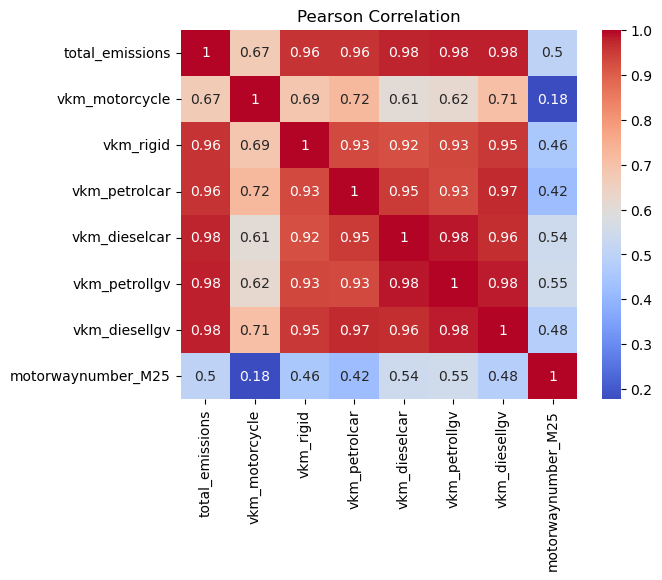

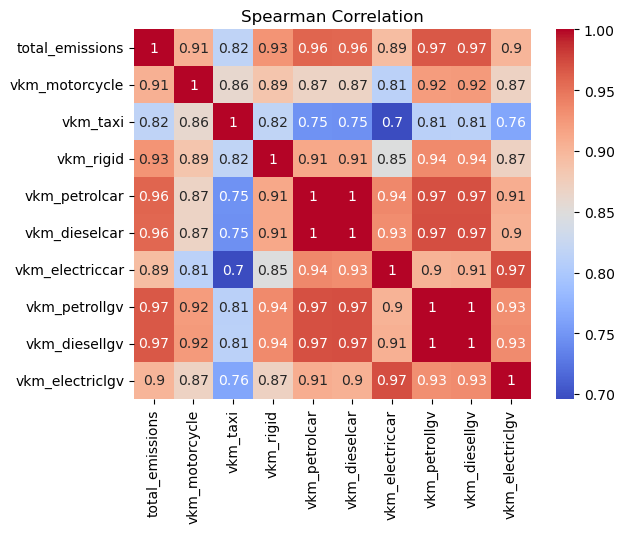

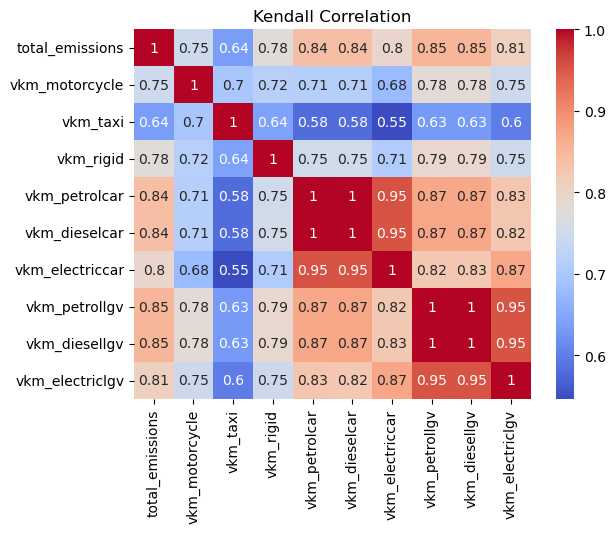

In [56]:
def correlation_heatmap(data, features, correlation_method):
    # Calculate correlation matrix
    corr_matrix = data[features].corr(method=correlation_method)

    # Create heatmap
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

    # Set the title of the heatmap
    plt.title(f"{correlation_method.capitalize()} Correlation")

    # Display the heatmap
    plt.show()
    
# Select the features and correlation method based on the extracted features
if len(pearson_features) > 0:
    selected_features = pearson_features
    correlation_method = 'pearson'
elif len(spearman_features) > 0:
    selected_features = spearman_features
    correlation_method = 'spearman'
elif len(kendall_features) > 0:
    selected_features = kendall_features
    correlation_method = 'kendall'
else:
    print("No features extracted.")

# Create a correlation heatmap for the selected features using the corresponding correlation method
correlation_heatmap(normalized_data, pearson_features, 'pearson')
correlation_heatmap(normalized_data, spearman_features, 'spearman')
correlation_heatmap(normalized_data, kendall_features, 'kendall')

In [57]:
# Chosen feature and target columns to train based on above analysis
columns = ['vkm_motorcycle', 
           'vkm_taxi', 
           'vkm_rigid', 
           'vkm_petrolcar', 
           'vkm_dieselcar', 
           'vkm_electriccar', 
           'vkm_petrollgv', 
           'vkm_diesellgv', 
           'vkm_electriclgv',
           'total_emissions']

In [58]:
df_model = normalized_data[columns]

# 6. Model Development And Evaluation

In this section, we will craft three regression models: Linear Regression, Random Forest Regressor, and LightGBM Regressor. Subsequently, we will establish a pipeline and create a parameter dictionary to outline the hyperparameters for each model. Following this, we will utilize GridSearchCV to systematically fit and evaluate each model across a range of hyperparameter combinations. Finally, we will delve into a comprehensive discussion of the results obtained through this process.

## 6.1. Train Test Split

In [59]:
# Define dependent and independent variables
y = df_model['total_emissions']
X = df_model.iloc[:, :-1]

In [60]:
# Split the data into train and test
# Random state has been set to 42 in order to get the same training and testing seperation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## 6.2. Initialize the Models

In [61]:
# Initialize the Models
lin = LinearRegression()
rfr = RandomForestRegressor(random_state=42)
lgb = LGBMRegressor(random_state=42)

## 6.3. Initialize the Hyper-parameters

In [62]:
# Parameters for Linear Regression
lin_param = {}
lin_param['Regressor'] = [lin]

# Parameters for RandomForest
rfr_param = {}
rfr_param['Regressor'] = [rfr]
# n_estimators determines the number of decision trees to be utilized.
rfr_param['Regressor__n_estimators'] = [50, 100]
# max_depth determines how deep a decision tree can be.
rfr_param['Regressor__max_depth'] = [3, 5, None]

# Parameters for LightGBM
lgb_param = {}
lgb_param['Regressor'] = [lgb]
# learning_rate controls the step size during the optimization process.
lgb_param['Regressor__learning_rate'] = [0.01, 0.05, 0.1, 0.2]
# num_leaves denotes the number of leaves or terminal nodes in each tree.
lgb_param['Regressor__num_leaves'] = [21, 31, 41]
# max_depth determines the maximum depth of each tree.
lgb_param['Regressor__max_depth'] = [-1, 10, 30]


In [63]:
# Create the pipeline
pipeline = Pipeline([('Regressor', RandomForestRegressor(random_state=42))])
params = [lin_param, rfr_param, lgb_param]

In [64]:
# Define multiple regression metrics
scoring_ = {
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'r2': 'r2'
}

## 6.4. GridSearchCV

In [65]:
%%time

# Given the constraints of time and resources available for model training, 
# we have opted to implement just three models and have restricted the number of hyperparameters. 
# This decision is aimed at reducing the overall computational complexity of the models. 
# It is noteworthy that, depending on the availability of additional time and resources, 
# both the number of models and the range of hyperparameters may be expanded in future iterations.
 
# Run the GridSearchCV
# This instance of GridSearchCV employs cross-validation for each specified model 
# with various hyperparameter combinations. 
# The parameter 'cv' is configured as 3, leading to the division of the dataset into three folds. 
# During each iteration, one fold serves as the testing set, while the remaining two folds 
# are utilized for training. 
# The instance computes scores and ranks for each iteration 
# based on the metrics defined in the "scoring_" dictionary.
# A verbosity level of 3 ('verbose' set to 3) is selected, 
# providing detailed information during the validation process. 
# Additionally, 'n_jobs' is set to -1, enabling the utilization of 
# all available computing resources to expedite the validation process. 
# This optimization helps in achieving faster results by parallelizing the computation tasks.

grid_search = GridSearchCV(pipeline, params, cv = 3, scoring = scoring_, refit='r2', verbose = 3, n_jobs= -1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 43 candidates, totalling 129 fits
CPU times: total: 1min 39s
Wall time: 3min 43s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'Regressor': [LinearRegression()]},
                         {'Regressor': [RandomForestRegressor(random_state=42)],
                          'Regressor__max_depth': [3, 5, None],
                          'Regressor__n_estimators': [50, 100]},
                         {'Regressor': [LGBMRegressor(random_state=42)],
                          'Regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
                          'Regressor__max_depth': [-1, 10, 30],
                          'Regressor__num_leaves': [21, 31, 41]}],
             refit='r2',
             scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                      'neg_mean_squared_error': 'neg_mean_squared_error',
                      'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                      'r2': 'r2'},
             verbose=3)

## 6.5. Model Evaluation

In [66]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('best model: ' +str(best_model))
print('best parameters: ' +str(best_params))
print('best score: ' +str(best_score))


# As displayed below, the Random Forest Regressor emerges as the optimal model, 
# achieving an R2 score of 0.987 in the evaluation.
# However, it is better to conduct a more in-depth evaluation.

best model: Pipeline(steps=[('Regressor', RandomForestRegressor(random_state=42))])
best parameters: {'Regressor': RandomForestRegressor(random_state=42), 'Regressor__max_depth': None, 'Regressor__n_estimators': 100}
best score: 0.9872391684556129


In [67]:
# Assign the grid search CV's results into a dataframe.
dd = pd.DataFrame(grid_search.cv_results_)

# Evaluate the scores
dd[['rank_test_neg_mean_squared_error', 'rank_test_neg_root_mean_squared_error', 'rank_test_neg_mean_absolute_error', 'rank_test_r2']].sort_values('rank_test_r2').head(3)


# As observed in the results presented below, the model (index: 6) securing the top rank
# in R2 score also attains the best positions in other evaluation metrics
# , including mean squared error, root mean squared error, and mean absolute error.


,rank_test_neg_mean_squared_error,rank_test_neg_root_mean_squared_error,rank_test_neg_mean_absolute_error,rank_test_r2
6,1,1,1,1
5,2,2,2,2
0,3,3,30,3


In [68]:
# Best Score
dd[dd.index==6]

# Although Random Forest Regressor including parameters as max_depth as None, n_estimators as 100 
# keeps the best rank, its mean fit time is more than 2 minutes
# , which is not exceptable for online models. 
# A solution is proposed further below.

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Regressor,param_Regressor__max_depth,param_Regressor__n_estimators,param_Regressor__learning_rate,param_Regressor__num_leaves,params,...,split2_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2
6,101.107965,0.160259,0.575991,0.0171,RandomForestRegressor(random_state=42),None,100,NaN,NaN,{'Regressor': RandomForestRegressor(random_sta...,...,-26.920413,-27.139946,0.244611,1,0.985788,0.9878,0.98813,0.987239,0.001035,1


In [69]:
# The Highest Performance
dd[dd['mean_fit_time']==dd['mean_fit_time'].min()]

# Linear Regression boasts the shortest mean fit time, clocking in at less than 1 second.
# Although its mean R2 score slightly lags behind the best model by 0.005 at 0.982, 
# in scenarios where time constraints outweigh the utmost precision, 
# this model becomes a favorable choice.

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Regressor,param_Regressor__max_depth,param_Regressor__n_estimators,param_Regressor__learning_rate,param_Regressor__num_leaves,params,...,split2_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,0.059421,0.008594,0.0,0.0,LinearRegression(),NaN,NaN,NaN,NaN,{'Regressor': LinearRegression()},...,-34.835706,-34.836631,0.424616,30,0.981301,0.981816,0.983399,0.982172,0.000893,3


## 6.6 Train and Test the Best Model

In [70]:
%%time
# Let's train the model using the hyperparameters that secured the top rank.

rfr_best = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
rfr_best.fit(X_train, y_train)

CPU times: total: 1min 38s
Wall time: 1min 43s


RandomForestRegressor(random_state=42)

In [71]:
# Test the model

y_pred = rfr_best.predict(X_test)

r2_score_ = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(r2_score_)
print(mae)
print(mse)
print(rmse)

# During this test, the model has achieved an even higher R2 score than gridsearchCV evaluation
# , reaching 0.991.

0.9911594316684599
25.81042435111982
3664.330413615048
60.53371303344152


## 6.7 Visualization of Results

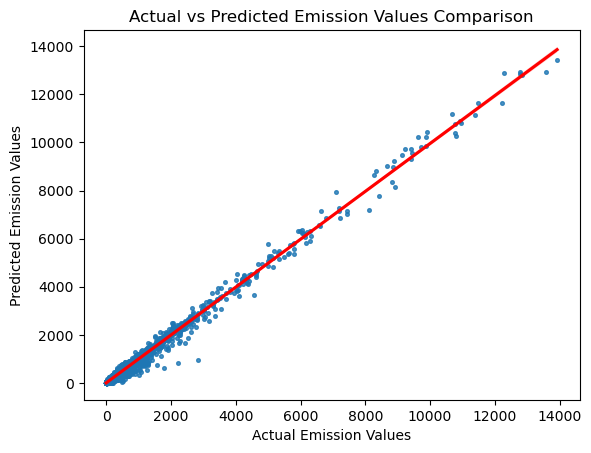

In [72]:
# Scatter plot with actual and predicted values
sns.regplot(x=y_test, y=y_pred
            , scatter_kws={'s': 7}
            , line_kws={'color': 'red'})
plt.xlabel('Actual Emission Values')
plt.ylabel('Predicted Emission Values')
plt.title('Actual vs Predicted Emission Values Comparison')
plt.show()

# As displayed in the below scatter plot, actual and predicted emission values
# follow a 45 degree straight trendline. Hence, we can visually observe the high accuracy of the model.